Allen-Mcguire

In [19]:
from pathlib import Path
import pandas as pd
import re

def extract_quarter_key(sheet_name):
    """
    Converts sheet names like 'Q2 2021' into a (year, quarter) tuple for sorting.
    """
    match = re.match(r"Q(\d)\s+(\d{4})", sheet_name)
    if match:
        q, y = match.groups()
        return int(y), int(q)
    return (0, 0)

def process_financials(company_name, 
                       raw_dir,
                       #out_dir=Path("data/processed")
                       ):
    """
    Processes the Excel file for a given company and saves quarterly financial data to a CSV file.
    """
    file_path = raw_dir / f"{company_name}.xlsx"
    if not file_path.exists():
        return None

    try:
        sheet_dict = pd.read_excel(file_path, sheet_name=None)
    except Exception:
        return None

    sorted_sheets = sorted(sheet_dict.items(), key=lambda x: extract_quarter_key(x[0]))

    records = []
    for sheet_name, df in sorted_sheets:
        try:
            temp = df.set_index(df.columns[0]).T
            temp["quarter"] = sheet_name
            temp["company"] = company_name
            records.append(temp)
        except Exception:
            continue

    if not records:
        return None

    financials_df = pd.concat(records, ignore_index=True)

    # company_dir = out_dir / company_name
    # company_dir.mkdir(parents=True, exist_ok=True)
    # result_df.to_csv(company_dir / "financials.csv", index=False)

    return financials_df


In [20]:
financials_df = process_financials(company_name='Allen-Mcguire', 
                               raw_dir=Path("C:/Users/felix.mcdonald/Projects/regent/regents_gate_reports/data/raw/financial_statements"),
                               # out_dir=Path("data/processed")
                                )

In [21]:
import pandas as pd
from pathlib import Path

# Point to the market data directory
market_dir = Path("C:/Users/felix.mcdonald/Projects/regent/regents_gate_reports/data/raw/market_data")

# Pick a file to inspect
file_path = next(market_dir.glob("*.parquet"))
df = pd.read_parquet(file_path)
# Check whether first row contains "last"
if df.iloc[0].eq("last").any():
    df = df.drop(index=0).reset_index(drop=True)

# Convert all columns to numeric (in case they're still strings)
df = df.apply(pd.to_numeric, errors='coerce')

# Create a placeholder date index (e.g., business days)
df["date"] = pd.date_range(start="2020-01-01", periods=len(df), freq="B")

# Convert from wide to tidy format
tidy = df.set_index("date").stack().reset_index()
# Drop the 'metric' column
df = tidy.drop(columns=["metric"])

# Set 'date' as index and stack
df = df.set_index("date")
market_df = df.stack().reset_index()

# Rename columns
market_df.columns = ["date", "figi", "last_price"]

In [22]:
from pathlib import Path
import json
import pandas as pd

def load_people(people_dir):
    records = []

    for file in people_dir.glob("*.json"):
        with open(file) as f:
            data = json.load(f)
            company_lei = data.get("lei")
            company_name = data.get("company_name")
            for person in data.get("people", []):
                records.append({
                    "lei": company_lei,
                    "company_name": company_name,
                    "person_name": person.get("name"),
                    "email": person.get("email"),
                    "title": person.get("title"),
                    "appointed": person.get("appointed")
                })

    return pd.DataFrame(records)
load_people(people_dir=Path("C:/Users/felix.mcdonald/Projects/regent/regents_gate_reports/data/raw/people"))
companies = pd.read_csv("C:/Users/felix.mcdonald/Projects/regent/regents_gate_reports/data/raw/companies/companies.csv")
people = load_people(people_dir=Path("C:/Users/felix.mcdonald/Projects/regent/regents_gate_reports/data/raw/people"))

people_df = pd.merge(people, companies, on="lei", how="left")


In [23]:
companies = r'C:\Users\felix.mcdonald\Projects\regent\regents_gate_reports\data\raw\companies\companies.csv'

In [24]:
data = pd.read_csv(companies)
companies_df = pd.DataFrame(data)

In [25]:
financials_df.to_csv("financials_df.csv", index=False)
market_df.to_csv("market_df.csv", index=False)
people_df.to_csv("people_df.csv", index=False)


In [26]:
financials_df.head(18)

Unnamed: 0,revenue,expenses,net_income,assets,liabilities,equity,cash,debt,equity_ratio,debt_ratio,quarter,company
0,66,25,50,25,90,12,3,68,3,88,Q1 2020,Allen-Mcguire
1,15,98,77,82,57,95,21,73,17,1,Q2 2020,Allen-Mcguire
2,96,95,37,83,64,73,86,63,38,35,Q3 2020,Allen-Mcguire
3,91,50,88,84,42,3,29,76,84,97,Q4 2020,Allen-Mcguire
4,29,40,11,49,24,94,39,68,69,36,Q1 2021,Allen-Mcguire
5,98,51,61,42,17,97,35,13,23,63,Q2 2021,Allen-Mcguire
6,41,55,74,41,99,38,55,46,5,74,Q3 2021,Allen-Mcguire
7,50,61,86,81,19,75,66,89,21,45,Q4 2021,Allen-Mcguire
8,46,90,17,28,12,22,51,61,31,8,Q1 2022,Allen-Mcguire
9,1,11,40,60,53,29,27,79,23,35,Q2 2022,Allen-Mcguire


In [27]:
from pathlib import Path

def process_company(company_row):
    lei = company_row["lei"]
    figi = company_row["figi"]
    name = company_row["name"]
    
    out_dir = Path("data/processed") / name
    out_dir.mkdir(parents=True, exist_ok=True)

    # Filter components
    profile = company_row.to_frame().T
    people = people_df[people_df["lei"] == lei]
    financials = financials_df[financials_df["company"] == name]  # match by name for now
    market = market_df[market_df["figi"] == figi]

    # Write each to its own file
    profile.to_csv(out_dir / "profile.csv", index=False)
    if not people.empty:
        people.to_csv(out_dir / "people.csv", index=False)
    if not financials.empty:
        financials.to_csv(out_dir / "financials.csv", index=False)
    if not market.empty:
        market.to_csv(out_dir / "market_data.csv", index=False)

# Apply for all companies
for _, row in companies_df.iterrows():
    process_company(row)


In [28]:
import pandas as pd

company = "Allen-Mcguire"
year = 2020
base_path = f"data/processed/{company}"

profile = pd.read_csv(f"{base_path}/profile.csv").iloc[0]
people = pd.read_csv(f"{base_path}/people.csv")
financials = pd.read_csv(f"{base_path}/financials.csv")
market = pd.read_csv(f"{base_path}/market_data.csv")


In [29]:
market["date"] = pd.to_datetime(market["date"])


In [30]:
market["date"]

0     2020-01-01
1     2020-01-02
2     2020-01-03
3     2020-01-06
4     2020-01-07
         ...    
257   2020-12-25
258   2020-12-28
259   2020-12-29
260   2020-12-30
261   2020-12-31
Name: date, Length: 262, dtype: datetime64[ns]

In [31]:
print("Available years:", sorted(market["date"].dt.year.unique()))

Available years: [2020]


In [32]:
market = market[market["date"].dt.year == year]
market.head(10)

,date,figi,last_price
0,2020-01-01,0-00-088889-3,61.104687
1,2020-01-02,0-00-088889-3,60.777750
2,2020-01-03,0-00-088889-3,61.279209
3,2020-01-06,0-00-088889-3,61.016742
4,2020-01-07,0-00-088889-3,60.369199
5,2020-01-08,0-00-088889-3,60.369199
6,2020-01-09,0-00-088889-3,60.222486
7,2020-01-10,0-00-088889-3,59.889654
8,2020-01-13,0-00-088889-3,60.053547
9,2020-01-14,0-00-088889-3,60.053547


In [33]:

# Rebase price to 100 for the first date in the year
market = market.sort_values("date")
market["rebased"] = 100 * market["last_price"] / market["last_price"].iloc[0]

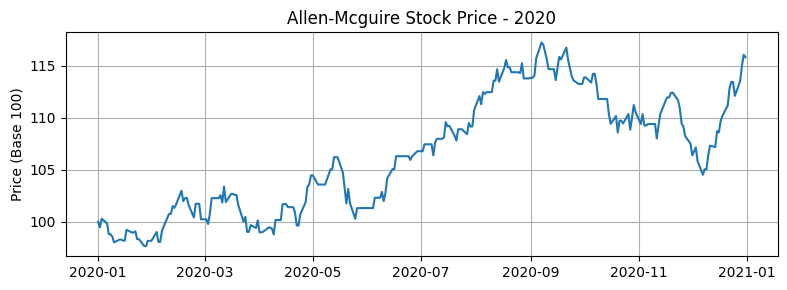

In [34]:
# Generate chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(market["date"], market["rebased"])
plt.title(f"{company} Stock Price - {year}")
plt.ylabel("Price (Base 100)")
plt.grid(True)
plt.tight_layout()
plt.savefig("stock_chart.png")
